In [1]:
import pandas as pd
from xgboost import XGBClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import shap
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = ['STFangsong']
plt.rcParams['axes.unicode_minus'] = False 


In [2]:
df = pd.read_csv("./data/raw/cell2celltrain.csv")
# print(df.columns)

In [3]:
# 列名映射字典
column_mapping = {
    # 标识与标签
    "CustomerID": "客户唯一标识",
    "Churn": "是否流失",

    # 收入与消费
    "MonthlyRevenue": "月均消费金额",
    "TotalRecurringCharge": "每月固定套餐费用",
    "PercChangeRevenues": "消费金额环比变化率",
    "HandsetPrice": "手机价格",
    "AdjustmentsToCreditRating": "信用评级调整次数",

    # 通话使用情况
    "MonthlyMinutes": "月通话分钟数",
    "OverageMinutes": "超出套餐的通话分钟数",
    "RoamingCalls": "漫游通话次数",
    "PercChangeMinutes": "通话分钟数环比变化率", 
    "ReceivedCalls": "接听电话次数",
    "OutboundCalls": "呼出电话次数",
    "InboundCalls": "呼入电话次数",
    "PeakCallsInOut": "高峰时段通话次数",
    "OffPeakCallsInOut": "非高峰时段通话次数",
    "ThreewayCalls": "三方通话次数",

    # 通话质量
    "DroppedCalls": "掉线次数",
    "BlockedCalls": "被阻塞的通话次数",
    "UnansweredCalls": "未接通电话次数",
    "DroppedBlockedCalls": "掉线与阻塞通话总次数",

    # 服务功能使用
    "CallForwardingCalls": "呼叫转移使用次数",
    "CallWaitingCalls": "呼叫等待使用次数",

    # 客服与挽留
    "CustomerCareCalls": "客服热线拨打次数",
    "DirectorAssistedCalls": "人工协助拨号次数",
    "RetentionCalls": "挽留部门通话次数",
    "MadeCallToRetentionTeam": "是否联系过挽留团队",
    "RetentionOffersAccepted": "是否接受挽留优惠",

    # 在网与订阅情况
    "MonthsInService": "在网时长（月）",
    "UniqueSubs": "唯一订阅数量",
    "ActiveSubs": "当前激活订阅数量",
    "ReferralsMadeBySubscriber": "推荐他人入网次数",

    # 终端与设备
    "Handsets": "拥有手机数量",
    "HandsetModels": "使用过的手机型号数",
    "CurrentEquipmentDays": "当前设备使用天数",
    "HandsetRefurbished": "是否使用翻新机",
    "HandsetWebCapable": "手机是否支持上网",
    "NewCellphoneUser": "是否新手机用户",
    "NotNewCellphoneUser": "是否非新手机用户",

    # 家庭与人口统计
    "AgeHH1": "家庭成员1年龄",
    "AgeHH2": "家庭成员2年龄",
    "ChildrenInHH": "家庭是否有儿童",
    "IncomeGroup": "收入水平分组",
    "MaritalStatus": "婚姻状况",
    "Occupation": "职业类别",

    # 资产与生活方式
    "Homeownership": "是否拥有住房",
    "OwnsComputer": "是否拥有电脑",
    "HasCreditCard": "是否持有信用卡",
    "OwnsMotorcycle": "是否拥有摩托车",
    "TruckOwner": "是否拥有卡车",
    "RVOwner": "是否拥有房车",
    "NonUSTravel": "是否有非美国出行经历",

    # 营销与沟通偏好
    "BuysViaMailOrder": "是否通过邮购方式消费",
    "RespondsToMailOffers": "是否响应过邮寄营销",
    "OptOutMailings": "是否拒绝接收邮件营销",

    # 地域与画像
    "ServiceArea": "服务区域",
    "PrizmCode": "PRIZM市场细分编码",

    # 信用
    "CreditRating": "信用评级"
}

df.rename(columns=column_mapping, inplace=True)
df


,客户唯一标识,是否流失,月均消费金额,月通话分钟数,每月固定套餐费用,人工协助拨号次数,超出套餐的通话分钟数,漫游通话次数,通话分钟数环比变化率,消费金额环比变化率,...,推荐他人入网次数,收入水平分组,是否拥有摩托车,信用评级调整次数,手机价格,是否联系过挽留团队,信用评级,PRIZM市场细分编码,职业类别,婚姻状况
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,0,9,No,1,10,No,1-Highest,Other,Professional,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,3399958,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,6,No,0,60,No,1-Highest,Suburban,Other,Yes
51043,3399974,No,95.17,1745.0,85.0,0.99,45.0,4.7,122.0,15.9,...,0,9,No,1,60,No,3-Good,Other,Other,No
51044,3399978,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,7,No,1,80,No,5-Low,Other,Clerical,No
51045,3399990,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,9,No,0,30,No,5-Low,Other,Other,No


In [4]:
# 非数值型列名
non_numeric_cols = ['是否流失', '服务区域', '家庭是否有儿童', '是否使用翻新机', '手机是否支持上网', '是否拥有卡车', '是否拥有房车','是否拥有住房', '是否通过邮购方式消费', '是否响应过邮寄营销', '是否拒绝接收邮件营销', '是否有非美国出行经历','是否拥有电脑', '是否持有信用卡', '是否新手机用户', '是否非新手机用户', '是否拥有摩托车', '手机价格','是否联系过挽留团队', '信用评级', 'PRIZM市场细分编码', '职业类别', '婚姻状况']

# 二元“yes/no”列
yes_no_cols = ['是否流失', '家庭是否有儿童', '是否使用翻新机', '手机是否支持上网', '是否拥有卡车', '是否拥有房车', '是否通过邮购方式消费', '是否响应过邮寄营销', '是否拒绝接收邮件营销', '是否有非美国出行经历', '是否拥有电脑', '是否持有信用卡', '是否新手机用户', '是否非新手机用户', '是否拥有摩托车', '是否联系过挽留团队']


# yes / no
for col in yes_no_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.strip()
        .str.lower()
        .map({"yes": 1, "no": 0})
        .astype("Int64")
    )

# known / unknown
df["是否拥有住房"] = (
    df["是否拥有住房"]
    .astype(str)
    .str.strip()
    .str.lower()
    .map({"known": 1, "unknown": 0})
    .fillna(0)
)

# 信用评级
if df["信用评级"].dtype == "object":
    df["信用评级"] = (
        df["信用评级"]
        .astype(str)
        .str.extract(r"(\d+)")
        .astype(float)
    )

# 手机价格
df["手机价格"] = pd.to_numeric(
    df["手机价格"], errors="coerce"
)

# One-Hot
cat_cols = ["PRIZM市场细分编码", "职业类别", "婚姻状况"]
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# 数值型列中位数填充
numeric_cols = df.select_dtypes(include="number").columns
df[numeric_cols] = df[numeric_cols].fillna(
    df[numeric_cols].median()
)

df


,客户唯一标识,是否流失,月均消费金额,月通话分钟数,每月固定套餐费用,人工协助拨号次数,超出套餐的通话分钟数,漫游通话次数,通话分钟数环比变化率,消费金额环比变化率,...,PRIZM市场细分编码_Town,职业类别_Crafts,职业类别_Homemaker,职业类别_Other,职业类别_Professional,职业类别_Retired,职业类别_Self,职业类别_Student,婚姻状况_Unknown,婚姻状况_Yes
0,3000002,1,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,False,False,False,False,True,False,False,False,False,False
1,3000010,1,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,False,False,False,False,True,False,False,False,False,True
2,3000014,0,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,True,True,False,False,False,False,False,False,False,True
3,3000022,0,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,False,False,False,True,False,False,False,False,False,False
4,3000026,1,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,3399958,1,48.46,366.0,45.0,0.25,3.0,0.0,-5.0,-0.3,...,False,False,False,True,False,False,False,False,False,True
51043,3399974,0,95.17,1745.0,85.0,0.99,45.0,4.7,122.0,15.9,...,False,False,False,True,False,False,False,False,False,False
51044,3399978,1,48.46,366.0,45.0,0.25,3.0,0.0,-5.0,-0.3,...,False,False,False,False,False,False,False,False,False,False
51045,3399990,0,48.46,366.0,45.0,0.25,3.0,0.0,-5.0,-0.3,...,False,False,False,True,False,False,False,False,False,False


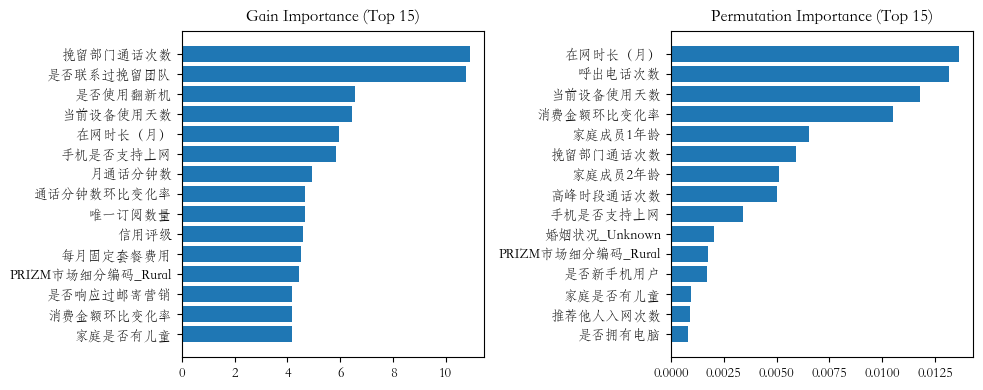

In [5]:
target = "是否流失"

X = df.drop(columns=[target, "客户唯一标识", "服务区域"])
y = df[target]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

model = XGBClassifier(
    objective="binary:logistic",
    n_estimators=600,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss",
    base_score=0.5
)

model.fit(X_train, y_train)

# Gain importance
gain_raw = model.get_booster().get_score(importance_type="gain")
feature_names = X.columns.tolist()

if all(k.startswith("f") for k in gain_raw):
    gain_importance = {
        feature_names[int(k[1:])]: v
        for k, v in gain_raw.items()
    }
else:
    gain_importance = gain_raw

gain_sorted = sorted(gain_importance.items(), key=lambda x: x[1], reverse=True)

# Permutation importance (F1)
perm = permutation_importance(
    model,
    X_valid,
    y_valid,
    n_repeats=5,
    random_state=42,
    n_jobs=-1,
    scoring="f1"
)

perm_importance = dict(zip(X.columns, perm.importances_mean))
perm_sorted = sorted(perm_importance.items(), key=lambda x: x[1], reverse=True)

# Plot feature importances
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.barh([f for f,_ in gain_sorted[:15]][::-1],
         [v for _,v in gain_sorted[:15]][::-1])
plt.title('Gain Importance (Top 15)')
plt.subplot(1,2,2)
plt.barh([f for f,_ in perm_sorted[:15]][::-1],
         [v for _,v in perm_sorted[:15]][::-1])
plt.title('Permutation Importance (Top 15)')
plt.tight_layout()
plt.show()


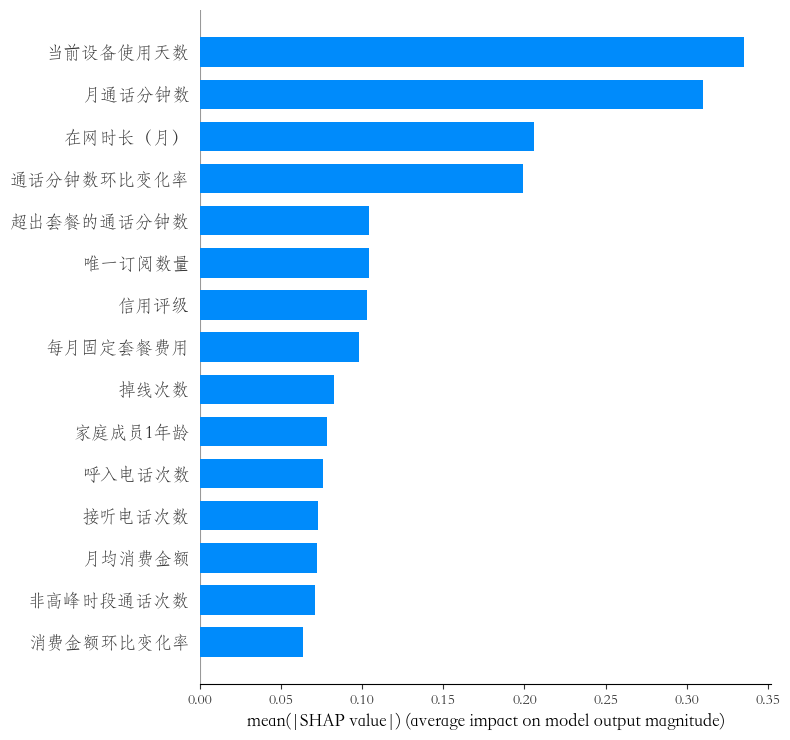

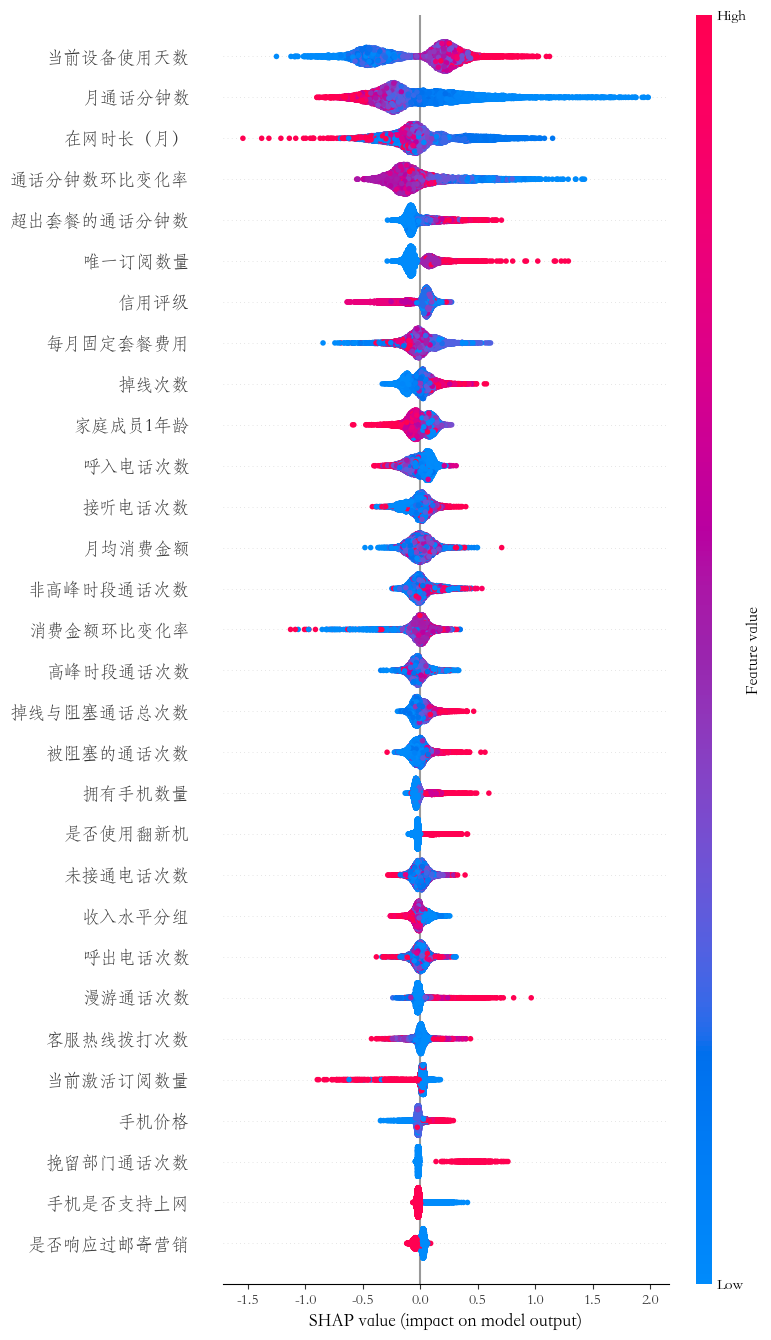

In [6]:
# SHAP values on validation set

explainer = shap.TreeExplainer(
    model,
    model_output="raw"
)
shap_values = explainer.shap_values(X_valid)

# Summary (bar) of mean |SHAP| values
plt.figure()
shap.summary_plot(shap_values, X_valid, plot_type='bar', max_display=15)

# Beeswarm for detailed distribution
shap.summary_plot(shap_values, X_valid, max_display=30)